In [29]:
import pandas as pd
import yfinance as yf

TICKERS = ["^GSPC", "^FCHI", "^STOXX50E"]

end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=10)

start, end


(Timestamp('2015-11-13 00:00:00'), Timestamp('2025-11-13 00:00:00'))

## Téléchargements : Appel multi-tickers 

In [30]:
raw = yf.download(
    TICKERS,
    start=start.date().isoformat(),
    end=end.date().isoformat(),
    interval="1d",
    group_by="ticker",
    auto_adjust=False,   # on veut les 4 prix bruts + Adj Close séparé
    actions=False,
    progress=False,
    threads=True
)
raw.tail()


Ticker        ^STOXX50E                                                      \
Price              Open         High          Low        Close    Adj Close   
Date                                                                          
2025-11-06  5665.589844  5672.370117  5606.569824  5611.180176  5611.180176   
2025-11-07  5617.819824  5633.750000  5554.529785  5566.529785  5566.529785   
2025-11-10  5608.669922  5677.490234  5608.669922  5664.459961  5664.459961   
2025-11-11  5670.939941  5730.990234  5670.939941  5725.700195  5725.700195   
2025-11-12  5734.680176  5804.660156  5734.680176  5787.310059  5787.310059   

Ticker                        ^FCHI                                         \
Price           Volume         Open         High          Low        Close   
Date                                                                         
2025-11-06  18667000.0  8016.669922  8044.859863  7950.799805  7964.770020   
2025-11-07  16857200.0  7986.069824  8000.990234  7908.589844  7950.180176   
2025-11-10  23607400.0  8044.089844  8077.180176  8017.470215  8055.509766   
2025-11-11  19400800.0  8080.600098  8169.799805  8078.220215  8156.229980   
2025-11-12  25359300.0  8190.680176  8280.969727  8185.029785  8241.240234   

Ticker                                     ^GSPC                            \
Price         Adj Close      Volume         Open         High          Low   
Date                                                                         
2025-11-06  7964.770020  62779100.0  6787.589844  6796.680176  6707.509766   
2025-11-07  7950.180176  52404200.0  6696.180176  6730.109863  6631.439941   
2025-11-10  8055.509766  52949300.0  6785.359863  6841.319824  6770.560059   
2025-11-11  8156.229980  47538300.0  6815.640137  6855.129883  6806.870117   
2025-11-12  8241.240234  61916100.0  6867.770020  6869.910156  6829.620117   

Ticker                                              
Price             Close    Adj Close        Volume  
Date                                                
2025-11-06  6720.319824  6720.319824  6.051900e+09  
2025-11-07  6728.799805  6728.799805  5.926070e+09  
2025-11-10  6832.430176  6832.430176  5.366050e+09  
2025-11-11  6846.609863  6846.609863  4.983490e+09  
2025-11-12  6850.919922  6850.919922  5.293610e+09

In [31]:
print(raw.shape)
print(raw.columns)

(2583, 18)
MultiIndex([('^STOXX50E',      'Open'),
            ('^STOXX50E',      'High'),
            ('^STOXX50E',       'Low'),
            ('^STOXX50E',     'Close'),
            ('^STOXX50E', 'Adj Close'),
            ('^STOXX50E',    'Volume'),
            (    '^FCHI',      'Open'),
            (    '^FCHI',      'High'),
            (    '^FCHI',       'Low'),
            (    '^FCHI',     'Close'),
            (    '^FCHI', 'Adj Close'),
            (    '^FCHI',    'Volume'),
            (    '^GSPC',      'Open'),
            (    '^GSPC',      'High'),
            (    '^GSPC',       'Low'),
            (    '^GSPC',     'Close'),
            (    '^GSPC', 'Adj Close'),
            (    '^GSPC',    'Volume')],
           names=['Ticker', 'Price'])


In [32]:
# 'raw' a des colonnes multi-index (Champ x Ticker). On empile le 1er niveau (tickers).
tidy = (
    raw.stack(level=0)
       .rename_axis(index=["date", "ticker"])
       .reset_index()
       .rename(columns={
           "Open": "open",
           "High": "high",
           "Low": "low",
           "Close": "close",
           "Adj Close": "adj_close",
           "Volume": "volume"
       })
       .sort_values(["ticker","date"])
       .reset_index(drop=True)
)

tidy.head()


/var/folders/90/0y2s7s2s13gg5ppzrhs4cb500000gn/T/ipykernel_227/1837895867.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  raw.stack(level=0)


Price,date,ticker,open,high,low,close,adj_close,volume
0,2015-11-13,^FCHI,4835.689941,4860.529785,4762.330078,4807.950195,4807.950195,114037800.0
1,2015-11-16,^FCHI,4756.919922,4824.020020,4751.029785,4804.310059,4804.310059,108609700.0
2,2015-11-17,^FCHI,4850.290039,4937.310059,4840.750000,4937.310059,4937.310059,119347400.0
3,2015-11-18,^FCHI,4901.120117,4918.140137,4879.359863,4906.720215,4906.720215,97351700.0
4,2015-11-19,^FCHI,4943.899902,4962.450195,4901.069824,4915.100098,4915.100098,103597200.0


In [33]:
print(tidy.shape)
print(tidy.columns)

(7588, 8)
Index(['date', 'ticker', 'open', 'high', 'low', 'close', 'adj_close',
       'volume'],
      dtype='object', name='Price')


In [34]:
summary = (
    tidy.groupby("ticker")
        .agg(first_date=("date","min"),
             last_date=("date","max"),
             rows=("date","size"),
             missing_volume=("volume", lambda s: int(s.isna().sum())))
)
summary


,first_date,last_date,rows,missing_volume
ticker,,,,
^FCHI,2015-11-13,2025-11-12,2560,0
^GSPC,2015-11-13,2025-11-12,2514,0
^STOXX50E,2015-11-13,2025-11-12,2514,0


In [22]:
from pathlib import Path
#Path("data/raw").mkdir(parents=True, exist_ok=True)

#tidy.to_parquet("data/raw/ohlcv_10y.parquet", index=False)
# tidy.to_csv("data/raw/ohlcv_10y.csv", index=False)  # si tu préfères CSV


In [35]:
import numpy as np

TICKERS = ["^GSPC", "^FCHI", "^STOXX50E"]  # déjà téléchargés dans `tidy`

# Fenêtres & lags de base (ajuste si besoin)
FE_WINDOWS = [5, 10, 20, 50, 100, 200]
FE_LAGS = [1, 2, 5, 10]
HORIZON_D = 1  # on prédit le retour à J+1

## Fonctions utilitaires 

In [39]:
def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    di = df["date"]
    df["dow"] = di.dt.dayofweek        # 0=Mon ... 4=Fri
    df["month"] = di.dt.month
    # .is_month_end / .is_quarter_end
    df["is_month_end"] = di.dt.is_month_end.astype(int)
    df["is_quarter_end"] = di.dt.is_quarter_end.astype(int)
    # semaine ISO et jour de l'année (optionnel)
    iso = di.dt.isocalendar()
    df["weekofyear"] = iso.week.astype(int)
    df["dayofyear"] = di.dt.dayofyear
    return df

def add_return_features(df: pd.DataFrame) -> pd.DataFrame:
    # retours basés sur CLOSE
    df["ret1"] = df["close"].pct_change()
    df["logret1"] = np.log(df["close"] / df["close"].shift(1))
    # lags de retours
    for L in FE_LAGS:
        df[f"ret_lag{L}"] = df["ret1"].shift(L)
        df[f"logret_lag{L}"] = df["logret1"].shift(L)
    return df

def add_ma_vol_features(df: pd.DataFrame) -> pd.DataFrame:
    # SMA/EMA sur CLOSE + volatilité (std des retours) + volume laggé
    for w in FE_WINDOWS:
        df[f"sma{w}"] = df["close"].rolling(w, min_periods=w).mean()
        df[f"ema{w}"] = df["close"].ewm(span=w, adjust=False, min_periods=w).mean()
        df[f"volstd{w}"] = df["ret1"].rolling(w, min_periods=w).std()
        df[f"vol_sma{w}"] = df["volume"].rolling(w, min_periods=w).mean()
    for L in FE_LAGS:
        df[f"vol_lag{L}"] = df["volume"].shift(L)
    return df

def add_atr(df: pd.DataFrame, n: int = 14) -> pd.DataFrame:
    # True Range = max(high-low, |high-prev_close|, |low-prev_close|)
    prev_close = df["close"].shift(1)
    tr = pd.concat([
        (df["high"] - df["low"]).abs(),
        (df["high"] - prev_close).abs(),
        (df["low"] - prev_close).abs()
    ], axis=1).max(axis=1)
    df["atr"] = tr.rolling(n, min_periods=n).mean()
    return df

def make_target(df: pd.DataFrame, horizon: int = 1) -> pd.DataFrame:
    # target = retour futur sur CLOSE
    df["target_ret"] = df["close"].pct_change(horizon).shift(-horizon)
    df["target_logret"] = (np.log(df["close"] / df["close"].shift(horizon))).shift(-horizon)
    return df

def build_features_one_ticker(tidy_one: pd.DataFrame, horizon: int = 1) -> pd.DataFrame:
    df = tidy_one.sort_values("date").copy()
    df = add_calendar_features(df)
    df = add_return_features(df)
    df = add_ma_vol_features(df)
    df = add_atr(df, n=14)
    df = make_target(df, horizon=horizon)

    # Nettoyage
    need_cols = ["ret1", "logret1", "atr", "target_ret"]
    need_cols += [f"sma{w}" for w in FE_WINDOWS] + [f"volstd{w}" for w in FE_WINDOWS]
    df = df.dropna(subset=need_cols).reset_index(drop=True)

    # ⚠️ Pas de standardisation ici : on garde les vraies échelles
    # (on pourra scaler dynamiquement plus tard dans le pipeline de modélisation)

    return df








In [42]:
features_by_ticker = {}
for t in TICKERS:
    one = tidy[tidy["ticker"] == t].copy()
    feat = build_features_one_ticker(one, horizon=HORIZON_D)
    features_by_ticker[t] = feat
    print(t, feat.shape, "de", one.shape)

# Exemples d’aperçu
features_by_ticker["^GSPC"].head()


^GSPC (2313, 55) de (2514, 8)
^FCHI (2359, 55) de (2560, 8)
^STOXX50E (2313, 55) de (2514, 8)


Price,date,ticker,open,high,low,close,adj_close,volume,dow,month,...,ema200,volstd200,vol_sma200,vol_lag1,vol_lag2,vol_lag5,vol_lag10,atr,target_ret,target_logret
0,2016-08-31,^GSPC,2173.560059,2173.790039,2161.350098,2170.949951,2170.949951,3.766390e+09,2,8,...,2081.273633,0.009228,3.947351e+09,3.006800e+09,2.654780e+09,3.148280e+09,3.388910e+09,12.512172,-0.000041,-0.000041
1,2016-09-01,^GSPC,2171.330078,2173.560059,2157.090088,2170.860107,2170.860107,3.392120e+09,3,9,...,2082.165041,0.009170,3.945606e+09,3.766390e+09,3.006800e+09,2.969310e+09,3.300570e+09,13.198591,0.004201,0.004192
2,2016-09-02,^GSPC,2177.489990,2184.870117,2173.590088,2179.979980,2179.979980,3.091120e+09,4,9,...,2083.138324,0.009173,3.938925e+09,3.392120e+09,3.766390e+09,3.342340e+09,3.084800e+09,13.502162,0.002982,0.002977
3,2016-09-06,^GSPC,2181.610107,2186.570068,2175.100098,2186.479980,2186.479980,3.447650e+09,1,9,...,2084.166599,0.009106,3.936531e+09,3.091120e+09,3.392120e+09,2.654780e+09,2.777550e+09,13.463588,-0.000146,-0.000146
4,2016-09-07,^GSPC,2185.169922,2187.870117,2179.070068,2186.159912,2186.159912,3.319420e+09,2,9,...,2085.181458,0.009106,3.934987e+09,3.447650e+09,3.091120e+09,3.006800e+09,3.041490e+09,13.050729,-0.002223,-0.002225


In [43]:
features_by_ticker["^GSPC"].tail()

Price,date,ticker,open,high,low,close,adj_close,volume,dow,month,...,ema200,volstd200,vol_sma200,vol_lag1,vol_lag2,vol_lag5,vol_lag10,atr,target_ret,target_logret
2308,2025-11-05,^GSPC,6769.770020,6829.779785,6763.109863,6796.290039,6796.290039,5.939600e+09,2,11,...,6229.481212,0.012582,5.227584e+09,5.739510e+09,6.065720e+09,6.280130e+09,5.710010e+09,66.677141,-0.011178,-0.011241
2309,2025-11-06,^GSPC,6787.589844,6796.680176,6707.509766,6720.319824,6720.319824,6.051900e+09,3,11,...,6234.365178,0.012604,5.236229e+09,5.939600e+09,5.739510e+09,6.052700e+09,5.565750e+09,67.680734,0.001262,0.001261
2310,2025-11-07,^GSPC,6696.180176,6730.109863,6631.439941,6728.799805,6728.799805,5.926070e+09,4,11,...,6239.284926,0.012599,5.243698e+09,6.051900e+09,5.939600e+09,6.398280e+09,5.058220e+09,68.989990,0.015401,0.015284
2311,2025-11-10,^GSPC,6785.359863,6841.319824,6770.560059,6832.430176,6832.430176,5.366050e+09,0,11,...,6245.186868,0.012640,5.249457e+09,5.926070e+09,6.051900e+09,6.065720e+09,5.290650e+09,74.874965,0.002075,0.002073
2312,2025-11-11,^GSPC,6815.640137,6855.129883,6806.870117,6846.609863,6846.609863,4.983490e+09,1,11,...,6251.171177,0.012594,5.248380e+09,5.366050e+09,5.926070e+09,5.739510e+09,5.695930e+09,72.174944,0.000630,0.000629


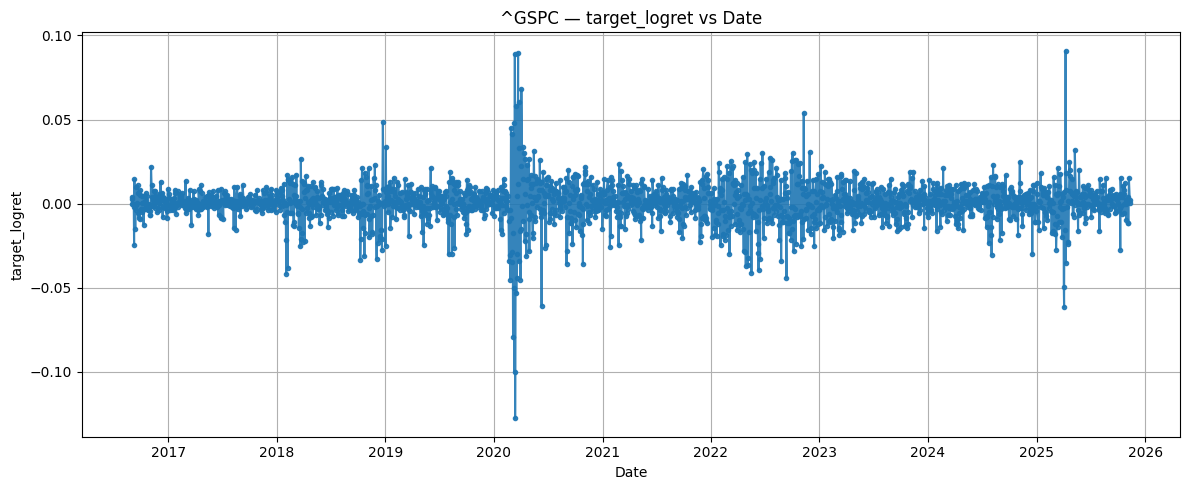

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# récupérer le DataFrame
df = features_by_ticker["^GSPC"].copy()

# convertir en datetime si nécessaire, ignorer les erreurs
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# supprimer les lignes sans date ou sans target
df = df.dropna(subset=['date', 'target_logret'])

# trier par date
df = df.sort_values('date')

# tracer
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['target_logret'], marker='.', linestyle='-', alpha=0.9)
plt.xlabel('Date')
plt.ylabel('target_logret')
plt.title('^GSPC — target_logret vs Date')
plt.grid(True)

# belle mise en forme de l'axe des x
ax = plt.gca()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()